# Spanning and Synchronization

This example shows how to model phases that span subtasks and how to
synchronize a meeting with attendees.


## Problem Description

Model phases that span subtasks and synchronize a meeting with attendees.
A phase spans its subtasks, and a meeting forces attendees to share the
same start and end times.

Objective: minimize the overall completion time.


## Mathematical Model

**Definitions:**

- $\text{span}(I, \{J_1, J_2, ...\})$: interval $I$ spans all intervals in the set
- $\text{synchronize}(I, \{J_1, J_2, ...\})$: all intervals share start and end times

**Constraints:**

- $\text{span}(\text{phase1}, \{\text{design}, \text{implement}\})$

- $\text{span}(\text{phase2}, \{\text{test}, \text{deploy}\})$

- $\text{end}(\text{phase1}) \le \text{start}(\text{phase2})$ 
- $\text{synchronize}(\text{meeting}, \{\text{alice}, \text{bob}, \text{carol}\})$

**Objective:**

- $\min \max(\text{end}(\text{phase2}), \text{end}(\text{meeting}))$

## Imports


In [1]:
# Imports
from pycsp3 import *
from pycsp3_scheduling import *  

## Problem Data


In [2]:
phase_tasks = {
    'design': 5,
    'implement': 10,
    'test': 4,
    'deploy': 2,
}

meeting_duration = 60
horizon = sum(phase_tasks.values()) + meeting_duration


## Build the Model


In [3]:
clear()
from pycsp3_scheduling.variables.interval import clear_interval_registry

clear_interval_registry()

design = IntervalVar(start=(0, horizon), end=(0, horizon), size=phase_tasks['design'], name='design')
implement = IntervalVar(start=(0, horizon), end=(0, horizon), size=phase_tasks['implement'], name='implement')
test = IntervalVar(start=(0, horizon), end=(0, horizon), size=phase_tasks['test'], name='test')
deploy = IntervalVar(start=(0, horizon), end=(0, horizon), size=phase_tasks['deploy'], name='deploy')

phase1 = IntervalVar(start=(0, horizon), end=(0, horizon), size=(0, horizon), name='phase1')
phase2 = IntervalVar(start=(0, horizon), end=(0, horizon), size=(0, horizon), name='phase2')

meeting = IntervalVar(start=(0, horizon), end=(0, horizon), size=meeting_duration, name='kickoff')
alice = IntervalVar(start=(0, horizon), end=(0, horizon), size=meeting_duration, name='alice')
bob = IntervalVar(start=(0, horizon), end=(0, horizon), size=meeting_duration, name='bob')
carol = IntervalVar(start=(0, horizon), end=(0, horizon), size=meeting_duration, name='carol')

satisfy(span(phase1, [design, implement]))
satisfy(span(phase2, [test, deploy]))
satisfy(end_before_start(phase1, phase2))
satisfy(synchronize(meeting, [alice, bob, carol]))


intension(function:eq(iv_s_7,iv_s_6))
intension(function:eq(add(iv_s_7,60),add(iv_s_6,60)))
intension(function:eq(iv_s_8,iv_s_6))
intension(function:eq(add(iv_s_8,60),add(iv_s_6,60)))
intension(function:eq(iv_s_9,iv_s_6))
intension(function:eq(add(iv_s_9,60),add(iv_s_6,60)))

In [4]:
objective_expr = Maximum(end_time(phase2), end_time(meeting))
minimize(objective_expr)


## Solve


In [5]:
result = solve()

if result in (SAT, OPTIMUM):
    print("Solution found." + (" (Optimal)" if result == OPTIMUM else ""))
    for iv in [design, implement, test, deploy, phase1, phase2, meeting, alice, bob, carol]:
        val = interval_value(iv)
        print(f"{iv.name}: [{val.start}, {val.end})")
    makespan = max(interval_value(phase2).end, interval_value(meeting).end)
    print(f"Makespan: {makespan}")
else:
    print("No solution found.")


Solution found. (Optimal)
design: [0, 5)
implement: [0, 10)
test: [10, 14)
deploy: [10, 12)
phase1: [0, 10)
phase2: [10, 14)
kickoff: [0, 60)
alice: [0, 60)
bob: [0, 60)
carol: [0, 60)
Makespan: 60


## Stats


In [6]:
print("Model statistics:", model_statistics())
if result in (SAT, OPTIMUM):
    objective_value = globals().get("makespan")
    print("Solution statistics:", solution_statistics(status=result, objective=objective_value))


Model statistics: ModelStatistics(nb_interval_vars=10, nb_optional_interval_vars=0, nb_sequences=0, nb_sequences_with_types=0, nb_cumul_functions=0, nb_state_functions=0)
Solution statistics: SolutionStatistics(status=OPTIMUM, objective_value=60, solve_time=None, nb_interval_vars=10, nb_intervals_present=10, nb_intervals_absent=0, min_start=0, max_end=60, makespan=60, span=60)


## Visualization


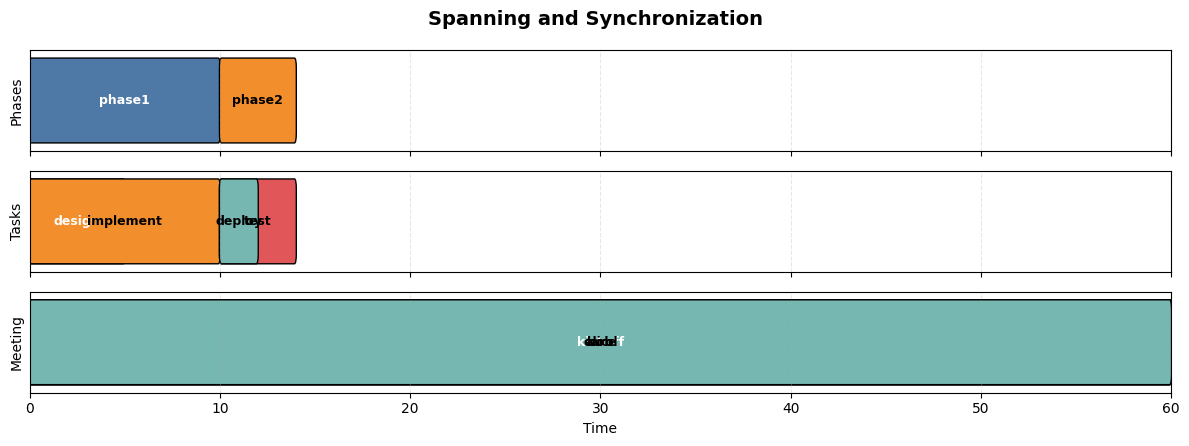

In [7]:
if result in (SAT, OPTIMUM):
    visu.reset()
    horizon = max(interval_value(phase2).end, interval_value(meeting).end)
    visu.timeline("Spanning and Synchronization", origin=0, horizon=horizon)

    visu.panel("Phases")
    p1 = interval_value(phase1)
    p2 = interval_value(phase2)
    visu.interval(p1.start, p1.end, phase1.name, color=0)
    visu.interval(p2.start, p2.end, phase2.name, color=1)

    visu.panel("Tasks")
    for idx, iv in enumerate([design, implement, test, deploy]):
        val = interval_value(iv)
        visu.interval(val.start, val.end, iv.name, color=idx)

    visu.panel("Meeting")
    for idx, iv in enumerate([meeting, alice, bob, carol]):
        val = interval_value(iv)
        visu.interval(val.start, val.end, iv.name, color=idx)

    if visu.is_visu_enabled():
        visu.show()
    else:
        print("Visualization disabled (matplotlib not available).")
